In [4]:
import numpy as np
import matplotlib.pyplot as plt

## predefined helper functions

In [5]:
def generate_random_state(num_cabinets,num_chemicals):
    return np.random.randint(low=0,high=num_cabinets,size=num_chemicals)
    
def evaluate_conflicts(state,dict_constraints,scaler=True):
    con_mat = np.zeros((len(state),len(state)))
    for key,value in dict_constraints.items():
        con_mat[key,list(np.array(value))] = 1
    
    ch_mat = np.zeros((len(state),len(state)))
    for c in range(len(state)):
        occ = np.where(np.array(state)==state[c])[0]
        ch_mat[occ,[c]] = 1
        
        conflicts = con_mat*ch_mat
    if(scaler):    
        return np.sum(conflicts)
    else: 
        return conflicts


def has_conflict(conflicts,action):
    #action (m,n): material m in slot n
    return action[0] in conflicts[action[1]]

## Read constraints

In [6]:
f = open('Dataset.txt', "r")
lines = f.readlines()
f.close()
lines = [l.strip() for l in lines]
data = []
for l in lines:
    temp = [int(l) for l in l.split(',')]
    data.append(temp)

dict_constraints = {}

for d in data:
    dict_constraints[d[0]-1] = [v - 1 for v in d[1:]]

## initial configuration

In [7]:
num_chemicals = 200
num_cabinets = 50
rounds = 500

In [8]:
#sample state
generate_random_state(5,10)
#index: chemical - value: cabinet

array([3, 0, 3, 2, 3, 4, 0, 2, 4, 0])

## simulated annealing


In [9]:
def mutate(state,num_cabinets):
    num_chemicals = len(state)
    i = np.random.randint(0, num_chemicals )
    state[i] = np.random.randint(0, num_chemicals )
    return state

In [10]:
def run_sa(dict_constraints,tempreture=10000,decay=0.95,num_cabinets=20,rounds=500,num_chemicals=200):
    
    state_c = generate_random_state(num_cabinets,num_chemicals) #stats_c : current state
    conflicts_log = []
    
    for i in range(rounds):
        conflicts_c = evaluate_conflicts( state_c , dict_constraints )
        state_n = mutate(state_c.copy(),num_cabinets) # state_n: candidate next state 
        conflicts_n = evaluate_conflicts(state_n,dict_constraints) # number of conflicts of candidate next state
        delta_e = conflicts_c  -  conflicts_n # next state conflicts - current state conflicts 
        acceptance_probability = np.exp( delta_e/tempreture ) 
        acceptance_probability = min(acceptance_probability,1) # probabilities cant be bigger than one
        randomNum = np.random.rand()
        if( acceptance_probability > randomNum ): # if acceptance probablity is >= a random number between 0 and 1. remember that we want to make it STOCHASTIC. u can use np.random.rand()
            state_c = state_n
            conflicts_log.append(conflicts_n)
            if( conflicts_n == 0 ): # if conflicts_n is zero, we have found an answer
                break
        else:
            conflicts_log.append(conflicts_c)
        
        tempreture = tempreture * np.exp(-decay)  # decrease temp with decay rate
        
    return conflicts_log,state_c

C:\Users\Asus\AppData\Local\Temp/ipykernel_8560/1011032082.py:11: RuntimeWarning: overflow encountered in exp
  acceptance_probability = np.exp( delta_e/tempreture )


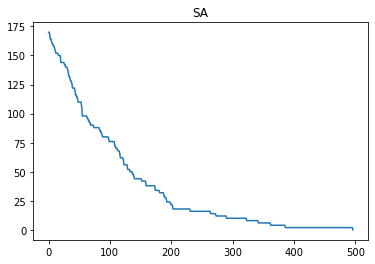

In [11]:
conflicts_log_sa,state_sa = run_sa(num_chemicals=num_chemicals,dict_constraints=dict_constraints,rounds=rounds,num_cabinets=num_cabinets)
plt.title('SA')
plt.plot(conflicts_log_sa,label='SA')
plt.show()

## Genectic Algorithm

In [12]:
def cross_over(state1,state2):
    cursor = np.random.randint(0,state1.size) # generate a random index between 0 and len(state)
    state3 = np.zeros_like(state1)
    # take one side of cursor from each state to make a new state
    if(np.random.rand()<0.5):
        # take first side from state 1 and second side of cursor from state 2
        state3[:cursor]= state1[:cursor]
        state3[cursor:] = state2[cursor:]
    else:
        # take first side from state 2 and second side of cursor from state 1
        state3[:cursor] = state2[:cursor]
        state3[cursor:] = state1[cursor:]
    return state3

In [13]:
# In our implementation of GA chromosome, state and character "c" are all the same. notice that these name can be used interchangably

def run_ga(dict_constraints,cpp=8,num_cabinets=20,rounds=500,num_chemicals=200): #cpp: chromosome per population
    population = []

    for i in range(cpp):
        population.append(generate_random_state( num_cabinets , num_chemicals ))
    
    conflicts_log = []
    for i in range(rounds):
        conflicts = []
        for chromosome in population: # chromosome/state in the population
            conflicts.append(evaluate_conflicts( chromosome , dict_constraints ))
        
        min_conflict = np.min(conflicts)
        conflicts_log.append(min_conflict)
        if( min_conflict==0 ): # the minimum conflicts is 0 so having 0 conflicts means that we have found an answer
            break
        
        # assign a probability to each chromosome with respect to its number of conflicts
        # write these probabilities to an array and call it selection_probabilities
        # Notic: chromosomes with more conflicts should have less selection probability and vice verca
        selection_probabilities = []
        
        conflicts=np.exp(np.array(conflicts-min_conflict)*-1)
        selection_probabilities = conflicts/sum(conflicts)

        
        new_population = []
        for i in range(cpp):
            # choose 2 random samples (chromosomes) from population. better samples should be chosen with higher probabilty
            c1_index,c2_index = np.random.choice(np.arange(cpp),2,True, selection_probabilities )
            c3 = cross_over( population[c1_index] , population[c2_index] )
            c3 = mutate( c3.copy() , num_cabinets )
            new_population.append(c3)
        
        population = new_population
        
    return conflicts_log,population[ np.argmin(conflicts) ] # the chromosome with least conflicts. u can use np.argmin
    # conflicts_log is just a report of how well the algorithms worked in each round.

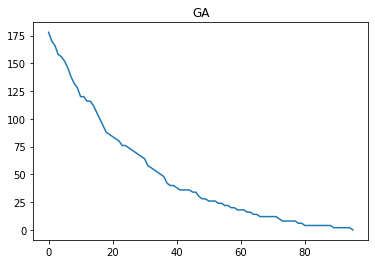

In [14]:
conflicts_log_ga,state_ga = run_ga(num_chemicals=num_chemicals,dict_constraints=dict_constraints,rounds=rounds,num_cabinets=num_cabinets)
plt.title('GA')
plt.plot(conflicts_log_ga,label='GA')
plt.show()

## Iterative Minimum Conflict

In [182]:
def next_greedy_state(state,num_cabinets,dict_constraints):
    
    conflicts_matrix = evaluate_conflicts(state=state,dict_constraints=dict_constraints,scaler=False)
    conflicts_per_chemical = np.sum(conflicts_matrix,axis=0)
    # conflicts_per_chemical is an array with shape (num_chemicals,1) that shows how many conflicts are caused by each chemical
    # you can print it to check it yourself.
    # choose the chemical that has caused biggest number of conflicts
    max_conflict_chemical = np.argmax( conflicts_per_chemical )
    state[ max_conflict_chemical ] = np.random.randint(0, num_cabinets) # change its cabinet to a random cabinet

    return state
            
def run_imc(dict_constraints,num_cabinets=20,num_chemicals=200,rounds=200):
    conflicts_log = []
    state = generate_random_state(num_cabinets,num_chemicals)
    for i in range( rounds ):
        # find a chemical with biggest number of conflicts and move to a another random cabinet
        state = next_greedy_state(  state  , num_cabinets , dict_constraints )
        conflicts = evaluate_conflicts( state , dict_constraints )
        conflicts_log.append( conflicts )
        if  (conflicts==0) : # conflicts is zero, we have found an answer
            break
    return conflicts_log,state
        

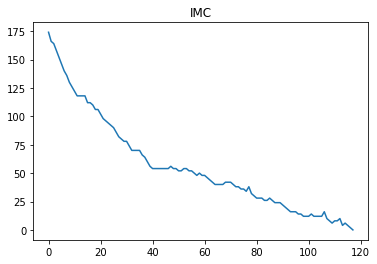

In [183]:
conflicts_log_imc,state_imc = run_imc(num_chemicals=num_chemicals,dict_constraints=dict_constraints,rounds=rounds,num_cabinets=num_cabinets)
plt.title('IMC')
plt.plot(conflicts_log_imc,label='IMC')
plt.show()

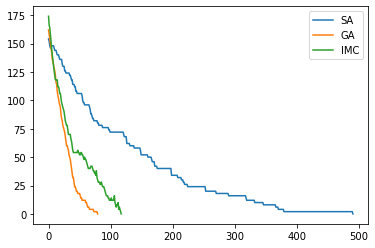

In [184]:
plt.plot(conflicts_log_sa,label='SA')
plt.plot(conflicts_log_ga,label='GA')
plt.plot(conflicts_log_imc,label='IMC')
plt.legend()
plt.show()

In [185]:
class Stack:
    "A cabinet with a last-in-first-out (LIFO) queuing policy."
    def __init__(self):
        self.list = []

    def push(self,item):
        "Push 'item' onto the stack"
        self.list.append(item)

    def pop(self):
        "Pop the most recently pushed item from the stack"
        return self.list.pop()

    def is_empty(self):
        "Returns true if the stack is empty"
        return len(self.list) == 0


class CSP_problem:
    def __init__(self,num_cabinets,num_chemicals,dict_constraints):
        self.num_cabinets = num_cabinets
        self.num_chemicals = num_chemicals
        self.dict_constraints = dict_constraints
        
    def get_successors(self,state):
        successors = []
        actions = np.arange(self.num_cabinets)
        unassigned_chemical_index = np.where(state==-1)[0][0]
        
        for action in actions:
            cost = 0
            next_state = state.copy()
            next_state[ unassigned_chemical_index ] =  action 
            if(np.sum(next_state==action)==1): # used an empty cabinet
                cost = 1
                
            # evaluate number of conflicts on this specific cabinet
            conflicts = self.evaluate_conflicts(next_state,unassigned_chemical_index,self.dict_constraints) 
            if( conflicts == 0 ):
                successors.append(( next_state , action , cost ))

        return successors
    
    
    def evaluate_conflicts(self,state,index,dict_constraints):
        conflicts = 0
        shared_set = set(np.where(state==state[index])[0])
        constraint_set = set(dict_constraints[index])
        conflicts += len(shared_set.intersection(constraint_set))

        return conflicts
            
            
    
#    def is_goal_state(self,state):
    def get_start_state(self):
        # start state is array: [-1,-1,-1 ..., -1] with shape(num_chemicals)
        # This means all of the chemicals are assigned to cabinet with index -1
        # which means we have not put them in any cabinet yet
        state = -np.ones(self.num_chemicals)
        return state
    
    def is_goal_state(self,state):
        return np.sum(state==-1)==0

def generic_search(problem, fringe, add_to_fringe_fn):
    start = (problem.get_start_state(), 0)  # (node, cost)
    add_to_fringe_fn(fringe, start, 0)
    visited_nodes_count = 0
    while not fringe.is_empty():
        (node,cost) = fringe.pop()
        visited_nodes_count +=1
        
        if problem.is_goal_state(node):
            return node,visited_nodes_count

        for child_node, child_action, child_cost in problem.get_successors(node):
            new_cost = cost + child_cost
            new_state = (child_node, new_cost)
            add_to_fringe_fn(fringe, new_state, new_cost)

            
def dfs(problem):
    fringe = Stack()
    def add_to_fringe_fn(fringe, state, cost):
        fringe.push(state)

    return generic_search(problem, fringe, add_to_fringe_fn)

def run_dfs(num_chemicals,num_cabinets,dict_constraints):
    problem = CSP_problem(num_cabinets,num_chemicals,dict_constraints)
    solution,visited_nodes_count = dfs(problem)
    return solution,visited_nodes_count

In [186]:
num_cabinets = 25

solution,visited_nodes_count = run_dfs(num_chemicals=num_chemicals,num_cabinets=num_cabinets,dict_constraints=dict_constraints)
conflicts = evaluate_conflicts(solution,dict_constraints)
if(conflicts == 0):

    print(f"There is a solution for putting {num_chemicals} chemicals in {num_cabinets} cabinets, while keeping the constraints satisfied")
else:
    print(f"there is NO solution for puting {num_chemicals} chemicals in {num_cabinets} cabinets,  while keeping the constraints satisfied")         

There is a solution for putting 200 chemicals in 25 cabinets, while keeping the constraints satisfied
